<a href="https://colab.research.google.com/github/dani222222/Ecualizador-en-cascada-de-octava/blob/main/Aplicacion_AutoGEQ_Gradiente_VS_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [1]:
!pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=4c1a0ab88826410be037ffafa183844c3751d45c1d25d936b4fcc9931422e183
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from IPython.display import Audio
from scipy.signal import welch
from pyswarm import pso
import time
from scipy.signal import butter, filtfilt

# Modelo de GEQ

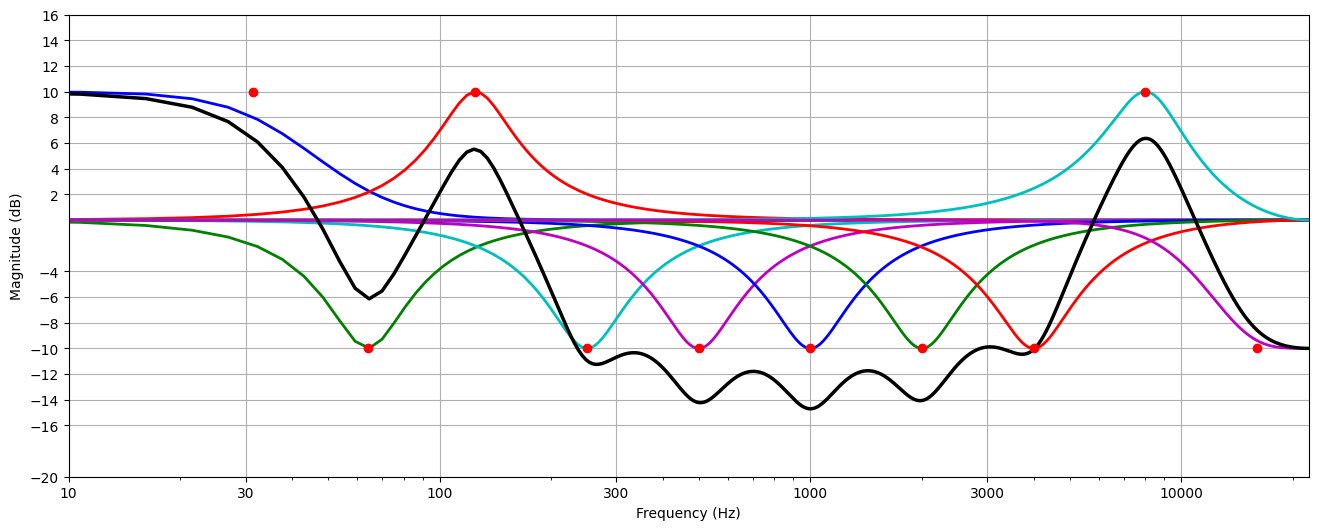

[ 15.62265982  -8.2141477    8.65863775 -13.92637805 -15.75948444
 -16.35616717 -15.59749731 -14.05070448   7.75382946 -10.4827432 ]


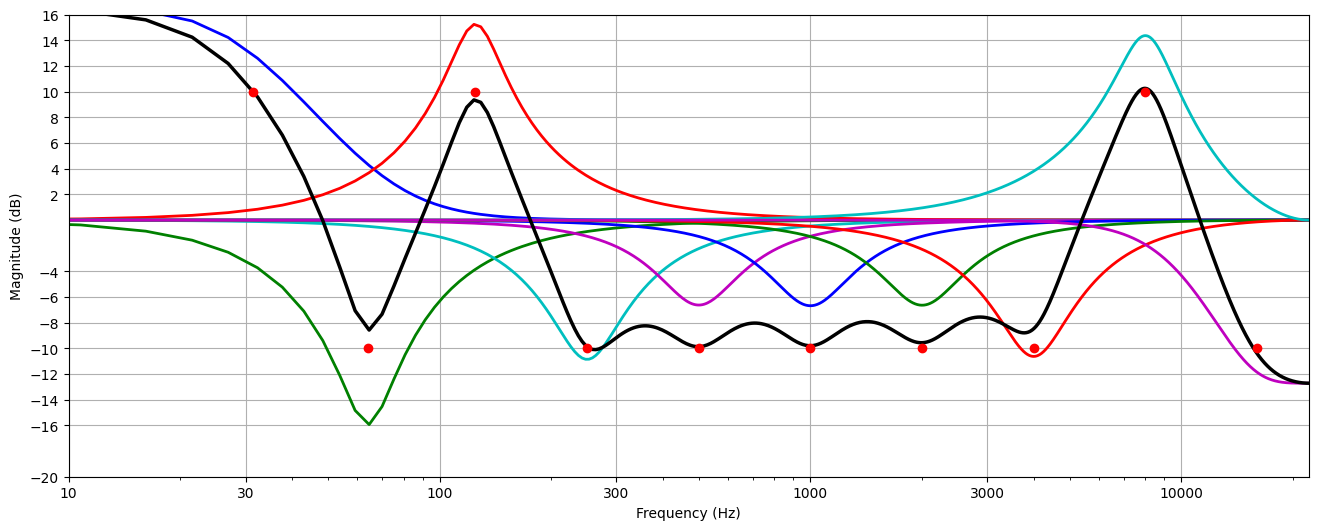

[ 13.74355598 -10.41930964   6.06641265 -17.03846526 -19.46980457
 -20.22380841 -18.84889193 -16.4877196    6.00771    -11.67406369]


In [3]:

# Parameters
fs = 44.1e3  # Sample rate
fc = np.array([31.5, 64, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])  # ISO center freqs.
wg = 2 * np.pi * fc / fs  # Command gain frequencies in radians
wc = 2 * np.pi * fc / fs  # Center frequencies in radians
wc[0] = 2 * np.pi * 46 / fs  # Modified crossover frequency for the lowest band
wc[9] = 2 * np.pi * 11360 / fs  # Modified crossover freq. for the highest band
bw = 1 * (np.sqrt(2) - 1 / np.sqrt(2)) * wc  # Bandwidth (constant Q) in radians

# Command gains
Gdb = [10, -10, 10, -10, -10, -10, -10, -10, 10, -10]  # Lista de decibeles para cada banda
#Gdb = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  # Lista de decibeles para cada banda
#Gdb = [10, 10, 10, 10, 10, -10, -10, -10, 10, -10]  # Lista de decibeles para cada banda
#Gdb = [2, 2, 2, 2, 2, 2, 2, 2, 2, 2]  # Lista de decibeles para cada banda
#Gdb = [-10, -10, -10, -10, -10, 10, 10, 10, 10, 10]  # Lista de decibeles para cada banda
G = 10 ** (np.array(Gdb) / 20)  # Convertir a factores de ganancia lineal

def freqz(num, den, worN, fs):
    """
    Filtro en frecuencia utilizando la transformada de Fourier.

    Devuelve la respuesta en frecuencia para un filtro digital `b` y `a`
    definido por coeficientes.

    Parámetros:
        b : array_like
            Coeficientes del numerador del filtro.
        a : array_like
            Coeficientes del denominador del filtro.
        worN : {None, int, array_like}, opcional
            Frecuencias en las que calcular la respuesta en frecuencia.
            Si es un entero, se utiliza como número de puntos de frecuencia.
            Si es una matriz, estas son las frecuencias.
            Si es None, se calcula automáticamente.
        fs : float, opcional
            Frecuencia de muestreo. Se utiliza para calcular las frecuencias
            si `worN` es un entero.

    Devuelve:
        w : array
            Frecuencias (en radianes / unidad de tiempo) en las que se calculó la respuesta en frecuencia.
        h : array
            Respuesta en frecuencia.
    """
    Frecuencias, H = signal.freqz(num, den, worN=worN, fs=fs)
    Magnitud = abs(H)
    return Frecuencias, Magnitud

# Trivial Cascade Graphic EQ Design
def shelf2low(G, wc):
    # Filter coefficients
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(1 / G) * Omega**2 + np.sqrt(2) * Omega * G**(-1/4) + 1
    a1 = 2 * (np.sqrt(1 / G) * Omega**2 - 1)
    a2 = np.sqrt(1 / G) * Omega**2 - np.sqrt(2) * Omega * G**(-1/4) + 1
    b0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    b1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    b2 = np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1

    # Transfer function
    den = [a0, a1, a2]
    num = [b0, b1, b2]
    return num, den


def peaknotch(G, wc, B):
    # Transfer function coefficients
    a0 = np.sqrt(G) + np.tan(B / 2)
    b0 = np.sqrt(G) + G * np.tan(B / 2)
    b1 = -2 * np.sqrt(G) * np.cos(wc)
    b2 = np.sqrt(G) - G * np.tan(B / 2)
    a1 = -2 * np.sqrt(G) * np.cos(wc)
    a2 = np.sqrt(G) - np.tan(B / 2)

    # Transfer function
    num = [b0, b1, b2]
    den = [a0, a1, a2]
    return num, den


def shelf2high(G, wc):
    # Filter coefficients
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    a1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    a2 = (np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1)
    b0 = np.sqrt(G) * (np.sqrt(G) + np.sqrt(2) * Omega * G**(1/4) + Omega**2)
    b1 = np.sqrt(G) * (2 * (-np.sqrt(G) + Omega**2))
    b2 = np.sqrt(G) * (np.sqrt(G) - np.sqrt(2) * Omega * G**(1/4) + Omega**2)

    # Transfer function
    den = [a0, a1, a2]
    num = [b0, b1, b2]
    return num, den


num1, den1 = shelf2low(G[0], wc[0])  # Low shelving filter
num2, den2 = peaknotch(G[1], wc[1], bw[1])  # Peak filter
num3, den3 = peaknotch(G[2], wc[2], bw[2])  # Peak filter
num4, den4 = peaknotch(G[3], wc[3], bw[3])  # Peak filter
num5, den5 = peaknotch(G[4], wc[4], bw[4])  # Peak filter
num6, den6 = peaknotch(G[5], wc[5], bw[5])  # Peak filter
num7, den7 = peaknotch(G[6], wc[6], bw[6])  # Peak filter
num8, den8 = peaknotch(G[7], wc[7], bw[7])  # Peak filter
num9, den9 = peaknotch(G[8], wc[8], bw[8])  # Peak filter
num10, den10 = shelf2high(G[9], wc[9])  # High shelving filter

# Calculate frequency responses
Nfreq = 4096  # Number of frequency points
w = np.logspace(np.log10(0.2), np.log10(22050), Nfreq)  # Log frequency points
w1, H1 = freqz(num1, den1, worN=Nfreq, fs=fs)
w2, H2 = freqz(num2, den2, worN=Nfreq, fs=fs)
w3, H3 = freqz(num3, den3, worN=Nfreq, fs=fs)
w4, H4 = freqz(num4, den4, worN=Nfreq, fs=fs)
w5, H5 = freqz(num5, den5, worN=Nfreq, fs=fs)
w6, H6 = freqz(num6, den6, worN=Nfreq, fs=fs)
w7, H7 = freqz(num7, den7, worN=Nfreq, fs=fs)
w8, H8 = freqz(num8, den8, worN=Nfreq, fs=fs)
w9, H9 = freqz(num9, den9, worN=Nfreq, fs=fs)
w10, H10 = freqz(num10, den10, worN=Nfreq, fs=fs)
Htot = H1 * H2 * H3 * H4 * H5 * H6 * H7 * H8 * H9 * H10  # Overall freq. response

# Optimized Cascade Graphic EQ Design
def compute_leak_factors(G, wg, wc, bw):
    N = len(wc)  # The number of filters
    leak = np.zeros((N, N))  # Initialize interaction matrix
    Gdb = 20 * np.log10(G)  # Convert linear gain factor to dB

    # Estimate leak factors of the first filter (second order low shelf filter)
    num1, den1 = shelf2low(G, wc[0])  # Low shelf filter
    H = np.abs(np.polyval(num1, np.exp(1j * wg)) / np.polyval(den1, np.exp(1j * wg)))  # Frequency response at center frequencies
    Gain = 20 * np.log10(H) / Gdb  # Normalized interference (Re 1 dB)
    leak[0, :] = np.abs(Gain)  # First row of interaction matrix

    # Estimate leak factors of the last filter (second order high shelf filter)
    numN, denN = shelf2high(G, wc[-1])  # High shelf filter
    H = np.abs(np.polyval(numN, np.exp(1j * wg)) / np.polyval(denN, np.exp(1j * wg)))  # Frequency response at center frequencies
    Gain = 20 * np.log10(H) / Gdb  # Normalized interference (Re 1 dB)
    leak[-1, :] = np.abs(Gain)  # Last row of interaction matrix

    # Estimate leak factors of peak/notch filters
    for k in range(1, N - 1):  # Band filters
        num, den = peaknotch(G, wc[k], bw[k])  # Design band filter
        H = np.abs(np.polyval(num, np.exp(1j * wg)) / np.polyval(den, np.exp(1j * wg)))  # Evaluate frequency response
        Gain = 20 * np.log10(H) / Gdb  # Normalized interference (Re 1 dB)
        leak[k, :] = np.abs(Gain)  # Store gain

    return leak


leak = compute_leak_factors(3.2, wg, wc, bw)  # Estimate leakage b/w bands
Goptdb = np.linalg.inv(leak) @ Gdb  # Solve optimal dB gains based on leakage
Gopt = 10 ** (Goptdb / 20)  # Convert to linear gain factors

# Calculate optimized filters
numopt1, denopt1 = shelf2low(Gopt[0], wc[0])  # Low shelving filter
numopt2, denopt2 = peaknotch(Gopt[1], wc[1], bw[1])
numopt3, denopt3 = peaknotch(Gopt[2], wc[2], bw[2])
numopt4, denopt4 = peaknotch(Gopt[3], wc[3], bw[3])
numopt5, denopt5 = peaknotch(Gopt[4], wc[4], bw[4])
numopt6, denopt6 = peaknotch(Gopt[5], wc[5], bw[5])
numopt7, denopt7 = peaknotch(Gopt[6], wc[6], bw[6])
numopt8, denopt8 = peaknotch(Gopt[7], wc[7], bw[7])
numopt9, denopt9 = peaknotch(Gopt[8], wc[8], bw[8])
numopt10, denopt10 = shelf2high(Gopt[9], wc[9])  # Low shelving filter

# Frequency responses
w1o, Hopt1 = freqz(numopt1, denopt1, worN=Nfreq, fs=fs)  # Frecuencia y magnitud de la respuesta
w2o, Hopt2 = freqz(numopt2, denopt2, worN=Nfreq, fs=fs)
w3o, Hopt3 = freqz(numopt3, denopt3, worN=Nfreq, fs=fs)
w4o, Hopt4 = freqz(numopt4, denopt4, worN=Nfreq, fs=fs)
w5o, Hopt5 = freqz(numopt5, denopt5, worN=Nfreq, fs=fs)
w6o, Hopt6 = freqz(numopt6, denopt6, worN=Nfreq, fs=fs)
w7o, Hopt7 = freqz(numopt7, denopt7, worN=Nfreq, fs=fs)
w8o, Hopt8 = freqz(numopt8, denopt8, worN=Nfreq, fs=fs)
w9o, Hopt9 = freqz(numopt9, denopt9, worN=Nfreq, fs=fs)
w10o, Hopt10 = freqz(numopt10, denopt10, worN=Nfreq, fs=fs)
# Overall frequency response:
Hopt = Hopt1 * Hopt2 * Hopt3 * Hopt4 * Hopt5 * Hopt6 * Hopt7 * Hopt8 * Hopt9 * Hopt10

# Figures

# Definir el tamaño deseado de la figura
fig_size = (16, 6)  # Ancho x Alto
linewidth = 2
# Crear la primera figura
plt.figure(1, figsize=fig_size)
plt.semilogx(w1, 20 * np.log10(H1), 'b', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w2, 20 * np.log10(H2), 'g', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w3, 20 * np.log10(H3), 'r', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w4, 20 * np.log10(H4), 'c', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w5, 20 * np.log10(H5), 'm', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w6, 20 * np.log10(H6), 'b', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w7, 20 * np.log10(H7), 'g', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w8, 20 * np.log10(H8), 'r', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w9, 20 * np.log10(H9), 'c', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w10, 20 * np.log10(H10), 'm', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w1, 20 * np.log10(Htot), 'k', linewidth=2.5) # Total response
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.plot(fc, Gdb, 'ro', linewidth=2)  # Command gains
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000])
plt.yticks([-16, -14, -12, -10, -8, -6, -4, -20, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.axis([10, 22050, min(-1, min(Gdb) - 10), max(0, max(Gdb) + 6)])
plt.grid(True)
plt.show()

# Compute gain error at center frequencies:
error_basic = Gdb - 20 * np.log10(Htot[np.array([893, 1015, 1136, 1258, 1380, 1503, 1625, 1747, 1870, 1991])])
print (error_basic)

# Crear la segunda figura
plt.figure(2, figsize=fig_size)
plt.semilogx(w1o, 20 * np.log10(Hopt1), 'b', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w2o, 20 * np.log10(Hopt2), 'g', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w3o, 20 * np.log10(Hopt3), 'r', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w4o, 20 * np.log10(Hopt4), 'c', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w5o, 20 * np.log10(Hopt5), 'm', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w6o, 20 * np.log10(Hopt6), 'b', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w7o, 20 * np.log10(Hopt7), 'g', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w8o, 20 * np.log10(Hopt8), 'r', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w9o, 20 * np.log10(Hopt9), 'c', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w10o, 20 * np.log10(Hopt10), 'm', linewidth=linewidth)
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.semilogx(w1o, 20 * np.log10(Hopt), 'k', linewidth=2.5)  # Total response
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.plot(fc, Gdb, 'ro', linewidth=2)  # Command gains
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000])
plt.yticks([-16, -14, -12, -10, -8, -6, -4, -20, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20])
plt.axis([10, 22050, min(-1, min(Gdb) - 10), max(0, max(Gdb) + 6)])
plt.grid(True)
plt.show()

# Compute gain error at center frequencies after optimization:
error_opt = Gdb - 20 * np.log10(Hopt[np.array([893, 1015, 1136, 1258, 1380, 1503, 1625, 1747, 1870, 1991])])
print (error_opt)

# Aplicación del GEQ a un ruido rosa.

Mounted at /content/drive


<ipython-input-4-8f4a73a9ccec>:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio = wavfile.read(ruta_audio)
<ipython-input-4-8f4a73a9ccec>:113: RuntimeWarning: invalid value encountered in log10
  spectrograms_db = 10 * np.log10(spectrograms + np.finfo(float).eps)


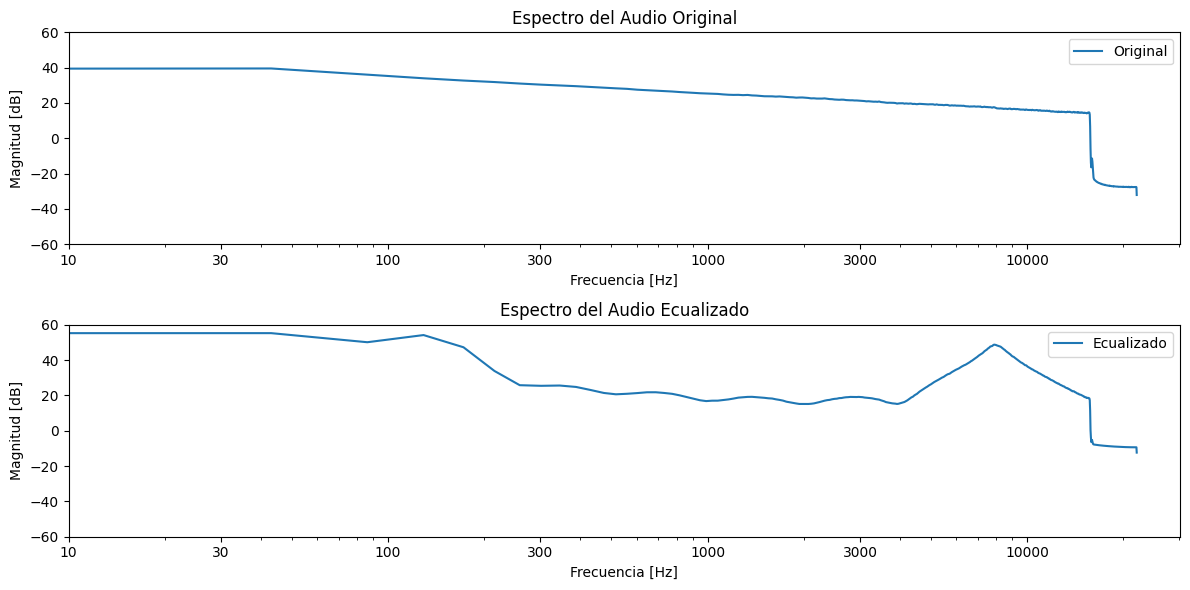

In [4]:

from google.colab import drive
drive.mount('/content/drive')

# Cargar el archivo de audio
ruta_audio = '/content/drive/My Drive/Archivos_prueba/Sonido de Ruido Rosa 1min.wav'
fs, audio = wavfile.read(ruta_audio)

# Asegurarse de que el audio es mono
if len(audio.shape) > 1:
    audio = audio[:, 0]

# Definir parámetros del ecualizador
fc = np.array([31.5, 64, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])  # Frecuencias centrales
wc = 2 * np.pi * fc / fs  # Frecuencias en radianes
wc[0] = 2 * np.pi * 46 / fs  # Modified crossover frequency for the lowest band
wc[9] = 2 * np.pi * 11360 / fs  # Modified crossover freq. for the highest band
bw = 1 * (np.sqrt(2) - 1 / np.sqrt(2)) * wc  # Ancho de banda

G = Gopt  # Ganancia para cada banda (debes ajustarla)

# Funciones para el diseño de los filtros
def shelf2low(G, wc):
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(1 / G) * Omega**2 + np.sqrt(2) * Omega * G**(-1/4) + 1
    a1 = 2 * (np.sqrt(1 / G) * Omega**2 - 1)
    a2 = np.sqrt(1 / G) * Omega**2 - np.sqrt(2) * Omega * G**(-1/4) + 1
    b0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    b1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    b2 = np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1
    return [b0, b1, b2], [a0, a1, a2]

def peaknotch(G, wc, B):
    Omega = np.tan(B / 2)
    a0 = 1 + Omega / G
    b0 = 1 + Omega * G
    b1 = -2 * np.cos(wc)
    b2 = 1 - Omega * G
    a1 = -2 * np.cos(wc)
    a2 = 1 - Omega / G
    return [b0, b1, b2], [a0, a1, a2]

def shelf2high(G, wc):
    Omega = np.tan(wc / 2)
    a0 = np.sqrt(G) * Omega**2 + np.sqrt(2) * Omega * G**(1/4) + 1
    a1 = 2 * (np.sqrt(G) * Omega**2 - 1)
    a2 = (np.sqrt(G) * Omega**2 - np.sqrt(2) * Omega * G**(1/4) + 1)
    b0 = np.sqrt(G) * (np.sqrt(G) + np.sqrt(2) * Omega * G**(1/4) + Omega**2)
    b1 = np.sqrt(G) * (2 * (-np.sqrt(G) + Omega**2))
    b2 = np.sqrt(G) * (np.sqrt(G) - np.sqrt(2) * Omega * G**(1/4) + Omega**2)
    return [b0, b1, b2], [a0, a1, a2]
##
# Calcular los coeficientes para cada banda
num1, den1 = shelf2low(Gopt[0], wc[0])  # Low shelving filter
num2, den2 = peaknotch(Gopt[1], wc[1], bw[1])
num3, den3 = peaknotch(Gopt[2], wc[2], bw[2])
num4, den4 = peaknotch(Gopt[3], wc[3], bw[3])
num5, den5 = peaknotch(Gopt[4], wc[4], bw[4])
num6, den6 = peaknotch(Gopt[5], wc[5], bw[5])
num7, den7 = peaknotch(Gopt[6], wc[6], bw[6])
num8, den8 = peaknotch(Gopt[7], wc[7], bw[7])
num9, den9 = peaknotch(Gopt[8], wc[8], bw[8])
num10, den10 = shelf2high(Gopt[9], wc[9])  # High shelving filter

# Almacenar los coeficientes en listas
num_filters = [num1, num2, num3, num4, num5, num6, num7, num8, num9, num10]
den_filters = [den1, den2, den3, den4, den5, den6, den7, den8, den9, den10]

# Función para aplicar los filtros
def apply_filters(audio, num_list, den_list):
    output = audio
    for num, den in zip(num_list, den_list):
        output = signal.lfilter(num, den, output)
    return output

# Aplicar los filtros al audio
audio_ecualizado = apply_filters(audio, num_filters, den_filters)
##

# Calcular la cantidad total de segmentos
segment_size = 1024  # Tamaño del segmento
overlap = 512  # Solapamiento entre segmentos
num_segments = (len(audio) - overlap) // (segment_size - overlap)
##
# Inicializar matrices para almacenar los espectros de potencia
spectrograms = []

for i in range(num_segments):
    # Calcular el inicio y fin del segmento actual
    start = i * (segment_size - overlap)
    end = start + segment_size

    # Aplicar ventana de Hamming al segmento
    segment = audio[start:end].astype(np.float64)
    hamming_window = np.hamming(segment_size).astype(np.float64)
    segment *= hamming_window

    # Calcular el espectro de potencia del segmento
    frequencies, Pxx = signal.periodogram(segment, fs=fs)

    # Asegurar que no hay valores no válidos en Pxx
    Pxx = np.clip(Pxx, 1e-10, None)  # Evita valores demasiado bajos

    # Almacenar el espectro de potencia en dB
    spectrograms.append(10 * np.log10(Pxx))
##
# Convertir la lista de espectrogramas en un arreglo numpy
spectrograms = np.array(spectrograms)

# Convertir la lista de espectrogramas en un arreglo numpy
spectrograms = np.array(spectrograms)

# Convertir la densidad espectral de potencia a decibeles
spectrograms_db = 10 * np.log10(spectrograms + np.finfo(float).eps)

# Graficar el espectro del audio original y ecualizado
plt.figure(figsize=(12, 6))

# Gráficos escalados logarítmicamente
plt.subplot(2, 1, 1)
plt.semilogx(frequencies, np.mean(spectrograms, axis=0).T, label='Original')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-60, 70, 20))
plt.ylim([-60, 60])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro del Audio Original')
plt.legend()

# Calcular el espectro del audio ecualizado con una ventana de tamaño fijo
frequencies_ec, magnitudes_ec = signal.welch(audio_ecualizado, fs=fs, window='hamming', nperseg=1024)

# Graficar el espectro del audio ecualizado
plt.subplot(2, 1, 2)
plt.semilogx(frequencies_ec, 10 * np.log10(magnitudes_ec + np.finfo(float).eps), label='Ecualizado')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-60, 70, 20))
plt.ylim([-60, 60])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro del Audio Ecualizado')
plt.legend()

plt.tight_layout()
plt.show()

# Guardar el audio ecualizado en un archivo WAV
#ruta_audio_ecualizado = '/content/drive/My Drive/Archivos_prueba/Sonido_Ecualizado.wav'
#wavfile.write(ruta_audio_ecualizado, fs, audio_ecualizado.astype(np.int16))

# Reproducir el audio original y ecualizado
#print("Audio Original:")
#display(Audio(audio, rate=fs))

#print("Audio Ecualizado:")
#display(Audio(audio_ecualizado, rate=fs))

# Función *PSO*

In [5]:
import gc

def clean_memory(*variables):
    """
    Limpia las variables especificadas de la memoria.

    Parámetros:
    *variables: Lista de variables a limpiar.
    """
    for var in variables:
        del var
    # Forzar la recolección de basura
    gc.collect()

# Función para calcular el error entre dos espectros
def calculate_error_spectrum(frequencies1, power_db1, frequencies2, power_db2):
    # Interpolar los espectros para tener las mismas frecuencias
    power_db1_interp = np.interp(frequencies2, frequencies1, power_db1)

    # Calcular errores
    mse = np.mean((power_db1_interp - power_db2) ** 2)  # Error Cuadrático Medio
    mae = np.mean(np.abs(power_db1_interp - power_db2))  # Error Absoluto Medio

    return mse, mae

# Función para ajustar las ganancias banda a banda (optimización por pares de bandas)
def adjust_bandwise(audio1, fc, bw, fs, power_rr_db, max_iter=10, epsilon=1e-3):
    # Inicializar ganancias aleatorias entre -10 y 10
    G = np.random.uniform(-9, 9, len(fc))

    best_fitness = float('inf')  # Mejor valor de fitness hasta ahora
    epsilon = 1e-3  # Criterio de convergencia para mejorar
    locked_bands = np.zeros(len(fc), dtype=bool)  # Bandas que ya no serán modificadas

    # Iterar para optimización global
    for iteration in range(max_iter):
        print(f"\nIteración {iteration + 1}/{max_iter}")

        # Iterar sobre las bandas en pares de dos
        for band_idx in range(0, len(fc), 2):
            if band_idx + 1 < len(fc) and locked_bands[band_idx] and locked_bands[band_idx + 1]:
                print(f"Banda {fc[band_idx]} Hz y {fc[band_idx + 1]} Hz bloqueadas, saltando optimización.")
                continue  # Saltar las bandas que ya están bloqueadas

            print(f"Optimizando bandas centradas en {fc[band_idx]} Hz y {fc[band_idx + 1]} Hz")

            # Función de fitness para dos bandas en particular
            def fitness_func_band(G_bands):
                G_temp = np.copy(G)  # Copiar las ganancias actuales
                G_temp[band_idx] = G_bands[0]  # Actualizar la primera banda
                if band_idx + 1 < len(fc):
                    G_temp[band_idx + 1] = G_bands[1]  # Actualizar la segunda banda si existe

                # Aplicar ecualizador al audio con las nuevas ganancias
                audio_eq = apply_eq(audio1, G_temp, fc, bw, fs)
                frequencies_eq, power_eq = signal.welch(audio_eq, fs=fs, window='hamming', nperseg=1024)
                power_eq_db = 10 * np.log10(power_eq + np.finfo(float).eps)

                # Fitness basado en la diferencia en el espectro entre audio ecualizado y ruido rosa
                fitness = np.sum((power_eq_db - power_rr_db) ** 2)

                return fitness

            # Ejecutar optimización para estas dos bandas
            G_opt_band, _ = pso(fitness_func_band, [-9, -9], [9, 9], swarmsize=20, maxiter=5)
            G[band_idx] = G_opt_band[0]  # Actualizar la ganancia de la primera banda
            if band_idx + 1 < len(fc):
                G[band_idx + 1] = G_opt_band[1]  # Actualizar la ganancia de la segunda banda si existe

            # Comprobar si el nuevo conjunto de ganancias es mejor
            audio_eq = apply_eq(audio1, G, fc, bw, fs)
            frequencies_eq, power_eq = signal.welch(audio_eq, fs=fs, window='hamming', nperseg=1024)
            power_eq_db = 10 * np.log10(power_eq + np.finfo(float).eps)
            fitness = np.sum((power_eq_db - power_rr_db) ** 2)

            # Evaluar si se bloquea individualmente cada banda
            if band_idx < len(fc):
                band_fitness_diff = np.abs(best_fitness - fitness)
                if band_fitness_diff < epsilon:
                    print(f"Banda {fc[band_idx]} Hz bloqueada debido a convergencia.")
                    locked_bands[band_idx] = True

            if band_idx + 1 < len(fc):
                band_fitness_diff_2 = np.abs(best_fitness - fitness)
                if band_fitness_diff_2 < epsilon:
                    print(f"Banda {fc[band_idx + 1]} Hz bloqueada debido a convergencia.")
                    locked_bands[band_idx + 1] = True

            # Actualizar el mejor fitness si hubo mejora
            if fitness < best_fitness:
                best_fitness = fitness
                print(f"Mejor fitness encontrado: {fitness}")

    return G

# Normalización del volumen del audio dañado con respecto al ruido rosa
def normalize_audio_to_reference(audio, reference):
    audio_rms = np.sqrt(np.mean(np.abs(audio)**2))
    reference_rms = np.sqrt(np.mean(reference**2))
    return audio * (reference_rms / audio_rms)

def fitness_func(G):
    # Aplicar ecualización con las ganancias G
    audio_eq = apply_eq(audio1, G, fc, bw, fs)

    # Calcular el espectro del audio ecualizado
    frequencies_eq, power_eq = signal.welch(audio_eq, fs=fs, window='hamming', nperseg=1024)
    power_eq_db = 10 * np.log10(power_eq + np.finfo(float).eps)

    # Ponderación de bandas críticas, con mayor control
    weight = np.ones_like(frequencies_o2)
    weight[(frequencies_o2 >= 250) & (frequencies_o2 <= 8000)] *= 2  # Mayor peso en frecuencias medias
    weight[frequencies_o2 < 250] *= 0.5  # Menor peso en frecuencias bajas
    weight[frequencies_o2 > 8000] *= 0.7  # Menor peso en frecuencias altas

    # Fitness basado en la diferencia ponderada entre el espectro del audio ecualizado y el ruido rosa
    # Se suaviza la penalización usando una regularización L2 para evitar mínimos locales
    spectral_error = np.sum(weight * (power_eq_db - power_rr_db) ** 2)

    # Regularización L2 para evitar soluciones extremas
    regularization = np.sum(G ** 2) * 0.01  # Factor de regularización para suavizar el ajuste

    # Penalización por ganancias fuera del rango permitido
    penalty = np.sum(np.abs(G) > 9) * 1000  # Penalización por valores fuera del rango [-9, 9] dB

    # Función final de fitness (error espectral + regularización + penalización)
    fitness = spectral_error + regularization + penalty

    return fitness

# PSO Callback para el seguimiento en cada iteración
def pso_callback(x):
    print(f"Iteración {pso_callback.iter_num}: Ganancias: {x}")
    pso_callback.iter_num += 1

# Inicializar contador de iteración para el callback
pso_callback.iter_num = 1

# Limitar el rango de frecuencias a analizar (solo las bandas del ecualizador)
def limit_freq_range(frequencies, power_db, fc):
    min_freq = fc[0] / 2
    max_freq = fc[-1] * 2
    mask = (frequencies >= min_freq) & (frequencies <= max_freq)
    return frequencies[mask], power_db[mask]


# Función para modificar los bits

In [6]:
# Función para convertir a 24 bits si no lo está
def convert_to_24bit(audio):
    if audio.dtype == np.int16:
        audio = audio.astype(np.float32) / 32768.0  # Convertir de 16 bits a flotante
    elif audio.dtype == np.int8:
        audio = audio.astype(np.float32) / 128.0  # Convertir de 8 bits a flotante
    audio = np.clip(audio, -1.0, 1.0)  # Asegurarse de que está en el rango [-1, 1]
    audio = (audio * 8388607).astype(np.int32)  # Convertir a 24 bits
    return audio

# Funciones de filtrado

In [7]:
# Definir funciones para los filtros
def peaknotch(G, fc, bw, fs):
    Q = 2 ** bw  # Q factor calculation based on bandwidth in octaves
    wc = 2 * np.pi * fc / fs
    alpha = np.sin(wc) / (2 * Q)
    A = 10 ** (G / 40)

    b0 = 1 + alpha * A
    b1 = -2 * np.cos(wc)
    b2 = 1 - alpha * A
    a0 = 1 + alpha / A
    a1 = -2 * np.cos(wc)
    a2 = 1 - alpha / A

    return np.array([b0, b1, b2]) / a0, np.array([a0, a1, a2]) / a0

def shelf2low(G, fc, fs):
    A = 10 ** (G / 40)  # Convertimos la ganancia de dB a escala lineal
    wc = 2 * np.pi * fc / fs
    Omega = np.tan(wc / 2)

    if G == 0:  # Si la ganancia es 0 dB, no se hace ajuste
        b0, b1, b2 = 1, 0, 0
        a0, a1, a2 = 1, 0, 0
    else:
        b0 = A * Omega**2 + np.sqrt(2 * A) * Omega + 1
        b1 = 2 * (A * Omega**2 - 1)
        b2 = A * Omega**2 - np.sqrt(2 * A) * Omega + 1
        a0 = Omega**2 + np.sqrt(2) * Omega + 1
        a1 = 2 * (Omega**2 - 1)
        a2 = Omega**2 - np.sqrt(2) * Omega + 1

    # Normalización de los coeficientes
    return np.array([b0, b1, b2]) / a0, np.array([a0, a1, a2]) / a0

def shelf2high(G, fc, fs):
    A = 10 ** (G / 40)  # Convertimos la ganancia de dB a escala lineal
    wc = 2 * np.pi * fc / fs
    Omega = np.tan(wc / 2)

    if G == 0:  # Si la ganancia es 0 dB, no se hace ajuste
        b0, b1, b2 = 1, 0, 0
        a0, a1, a2 = 1, 0, 0
    else:
        b0 = A + np.sqrt(2 * A) * Omega + Omega**2
        b1 = 2 * (Omega**2 - A)
        b2 = A - np.sqrt(2 * A) * Omega + Omega**2
        a0 = 1 + np.sqrt(2) * Omega + Omega**2
        a1 = 2 * (Omega**2 - 1)
        a2 = 1 - np.sqrt(2) * Omega + Omega**2

    # Normalización de los coeficientes
    return np.array([b0, b1, b2]) / a0, np.array([a0, a1, a2]) / a0

def normalize_audio_to_spectrum(audio, power_rr_db, fc, fs, learning_rate=0.1, tolerance=3, max_iterations=10):
    # Ajuste inicial basado en el espectro de referencia (ruido rosa)
    for iteration in range(max_iterations):
        print(f"Iteración {iteration + 1} del ajuste previo")

        # Obtener el espectro del audio actual
        frequencies, power = signal.welch(audio, fs=fs, window='hamming', nperseg=1024)
        power_db = 10 * np.log10(power + np.finfo(float).eps)

        # Ajuste en cada banda de frecuencia
        for i in range(len(fc)):
            idx = np.argmin(np.abs(frequencies - fc[i]))
            idx_rr = np.argmin(np.abs(frequencies - fc[i]))

            if idx < len(power_db) and idx_rr < len(power_rr_db):
                # Diferencia entre el espectro del audio y el ruido rosa
                difference = power_db[idx] - power_rr_db[idx_rr]

                # Ajustar si la diferencia excede el umbral de -24 dB
                if difference > -24:
                    audio *= 10 ** (-learning_rate * difference / 20)

        # Verificar si todas las bandas están dentro del margen de tolerancia
        power_db_fc = np.array([power_db[np.argmin(np.abs(frequencies - f))] for f in fc])
        power_rr_db_fc = np.array([power_rr_db[np.argmin(np.abs(frequencies - f))] for f in fc])

        all_within_tolerance = np.all(np.abs(power_db_fc - power_rr_db_fc) <= tolerance)
        if all_within_tolerance:
            print("El audio está alineado con el espectro del ruido rosa")
            break

    return audio


# Aplicar el ecualizador
def apply_eq(audio, G, fc, bw, fs):
    # Convert audio to float64 for lfilter
    output = audio.astype(np.float64)
    for i in range(len(G)):
      if i == 0:
        num, den = shelf2low(G[i], fc[i], fs)
        output = signal.lfilter(num, den, output)
      elif i == 9:
        num, den = shelf2high(G[i], fc[i], fs)
        output = signal.lfilter(num, den, output)
      else:
        num, den = peaknotch(G[i], fc[i], bw[i], fs)
        output = signal.lfilter(num, den, output)
    return output

# Función para verificar y ajustar las ganancias
def adjust_gains(audio, G, fc, bw, fs, power_rr_db, tolerance=3, max_iterations=10, learning_rate=0.1):
    for iteration in range(max_iterations):
        audio_ecualizado = apply_eq(audio, G, fc, bw, fs)
        frequencies, power = signal.welch(audio_ecualizado, fs=fs, window='hamming', nperseg=1024)
        power_db = 10 * np.log10(power + np.finfo(float).eps)

        # Comparar banda por banda y ajustar ganancias si es necesario
        for i in range(len(fc)):
            idx = np.argmin(np.abs(frequencies - fc[i]))
            idx_rr = np.argmin(np.abs(frequencies_rr - fc[i]))

            if idx < len(power_db) and idx_rr < len(power_rr_db):
                difference = power_db[idx] - power_rr_db[idx_rr]

                # Evitar ajustar ganancias si la diferencia está por debajo de -24 dB
                if difference < -24:
                    continue

                # Gradiente descendente para ajustar las ganancias
                G[i] -= learning_rate * difference

                # Asegurarse de que las ganancias no se descontrolen
                G[i] = np.clip(G[i], -24, 24)

        # Verificar si todas las bandas están dentro del margen
        indices_fc = np.array([np.argmin(np.abs(frequencies - f)) for f in fc])
        power_db_fc = power_db[indices_fc]
        power_rr_db_fc = np.array([power_rr_db[np.argmin(np.abs(frequencies_rr - f))] for f in fc])

        power_db_fc = power_db_fc[:len(fc)]
        power_rr_db_fc = power_rr_db_fc[:len(fc)]

        all_within_tolerance = np.all(
            np.abs(power_db_fc - power_rr_db_fc) <= tolerance
        )
        if all_within_tolerance:
            break

    return G, audio_ecualizado

def flatten_high_frequencies(audio, frequencies, power_db, power_rr_db, fs, threshold=10):
    """
    Aplana las frecuencias altas que exceden la referencia del ruido rosa y limita las frecuencias
    y potencias al rango en el que la referencia tiene datos válidos.
    """

    # Identificar la frecuencia máxima en la referencia
    max_ref_freq_idx = np.max(np.where(~np.isnan(power_rr_db))[0])  # Última frecuencia con referencia válida
    max_ref_freq = frequencies[max_ref_freq_idx]

    # Solo modificar las frecuencias por encima de 16 kHz y hasta la frecuencia máxima de la referencia
    high_freq_idx = np.where((frequencies >= 16000) & (frequencies <= max_ref_freq))[0]
    power_db_high = power_db[high_freq_idx]
    power_rr_db_high = power_rr_db[high_freq_idx]

    # Identificar las frecuencias que exceden el umbral de 10 dB por encima del ruido rosa
    excess_idx = np.where(power_db_high > power_rr_db_high + threshold)[0]

    # Aplicar atenuación a las frecuencias que exceden el umbral
    if len(excess_idx) > 0:
        for idx in excess_idx:
            attenuation_db = power_db_high[idx] - power_rr_db_high[idx]
            audio = apply_attenuation(audio, frequencies[high_freq_idx[idx]], attenuation_db, fs)

    # Eliminar las frecuencias superiores a la máxima frecuencia de referencia
    valid_idx = np.where(frequencies <= max_ref_freq)[0]  # Índices de frecuencias válidas

    # Filtrar las frecuencias y sus potencias correspondientes
    frequencies_filtered = frequencies[valid_idx]
    power_db_filtered = power_db[valid_idx]

    # Recalcular el espectro del audio modificado
    frequencies_mod, power_mod = signal.welch(audio, fs=fs, window='hamming', nperseg=1024)
    power_mod_db = 10 * np.log10(power_mod + np.finfo(float).eps)

    # Limitar nuevamente el espectro modificado a las frecuencias válidas
    mod_valid_idx = np.where(frequencies_mod <= max_ref_freq)[0]
    frequencies_mod_filtered = frequencies_mod[mod_valid_idx]
    power_mod_db_filtered = power_mod_db[mod_valid_idx]

    # Igualar el final del espectro modificado con la tendencia del ruido rosa
    power_trend_rr = power_rr_db[valid_idx]  # Tendencia del ruido rosa hasta la máxima frecuencia válida
    transition_length = 10  # Longitud de la transición para suavizar el ajuste final
    power_mod_db_filtered[-transition_length:] = power_trend_rr[-transition_length:]

    return audio, frequencies_mod_filtered, power_mod_db_filtered

def apply_attenuation(audio, fc, attenuation_db, fs):
    """
    Aplica atenuación a una frecuencia específica en una señal de audio.
    """

    # Calcular la ganancia en escala lineal
    gain = 10**(attenuation_db / 20)

    # Calcular la frecuencia de corte como una fracción de la frecuencia de Nyquist
    cutoff = fc / (fs / 2)

    # Asegurar que la frecuencia de corte esté dentro del rango válido (0 < cutoff < 1)
    cutoff = np.clip(cutoff, 0.01, 0.99)

    # Calcular el ancho de banda como una fracción de la frecuencia de Nyquist
    bandwidth = 0.05  # Ajustar según sea necesario

    # Asegurar que las frecuencias de corte del filtro estén dentro del rango válido
    Wn = [cutoff - bandwidth, cutoff + bandwidth]
    Wn = np.clip(Wn, 0.01, 0.99)

    # Crear filtro para atenuar la frecuencia especificada
    b, a = signal.butter(4, Wn, btype='bandstop')
    audio_filtered = signal.lfilter(b, a, audio)

    return audio_filtered

# Prueba Cumbia - Talento en TV

<ipython-input-8-37f81817a291>:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, ruido_rosa = wavfile.read('/content/drive/My Drive/Archivos_prueba/Sonido de Ruido Rosa 1min.wav')


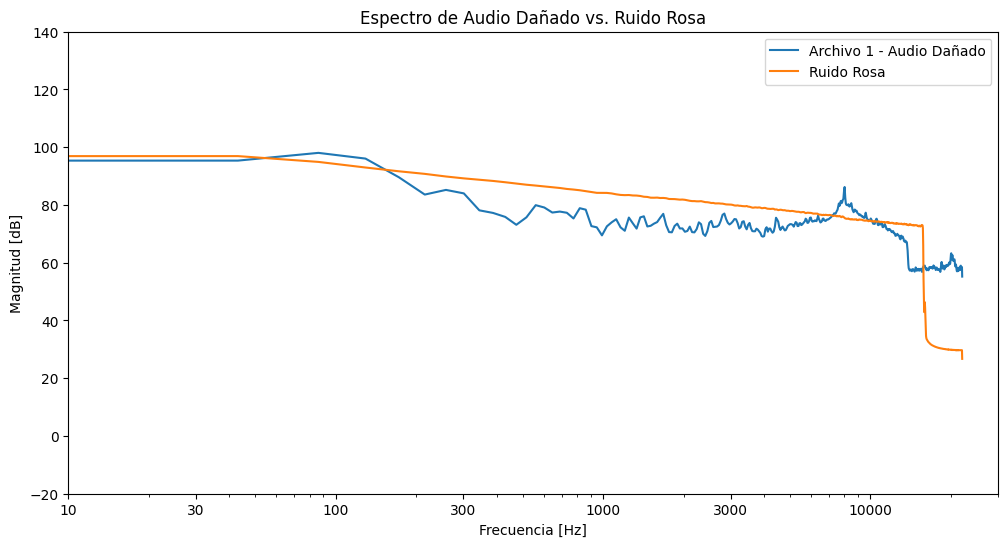

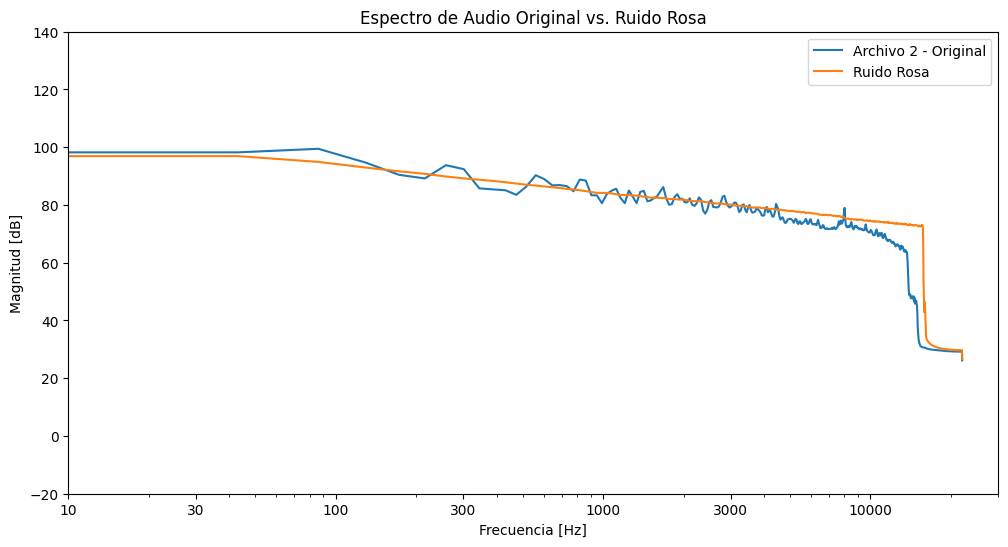

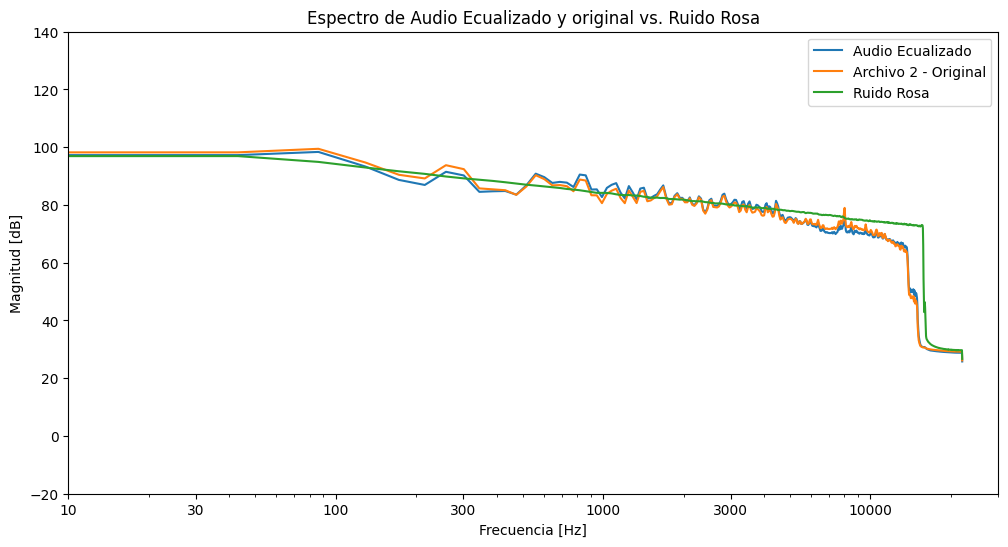

------ ------ ------
Tiempo transcurrido: 00:00:22


In [8]:
# Marcar el tiempo inicial
start_time = time.time()

# Cargar los archivos de audio

# Cancion Dañada
fs, audio1 = wavfile.read('/content/drive/My Drive/Archivos_prueba/Sonido_Dañado.wav')
audio1 = convert_to_24bit(audio1)

# Ruido Rosa
_, ruido_rosa = wavfile.read('/content/drive/My Drive/Archivos_prueba/Sonido de Ruido Rosa 1min.wav')
ruido_rosa = convert_to_24bit(ruido_rosa)

# Cancion original
fs2, audio2 = wavfile.read('/content/drive/My Drive/Archivos_prueba/SONORA-DINAMITA-TALENTO-DE-TELEVISION-canta-NANDO-MALO1.wav')
audio2 = convert_to_24bit(audio2)

# Asegurarse de que el audio es mono
if len(audio1.shape) > 1:
    audio1 = audio1[:, 0]

if len(audio2.shape) > 1:
    audio2 = audio2[:, 0]

# Calcular el espectro del ruido rosa (asegurarse de que sea mono)
ruido_rosa_mono = ruido_rosa[:, 0] if len(ruido_rosa.shape) > 1 else ruido_rosa
frequencies_rr, power_rr = signal.welch(ruido_rosa_mono, fs=fs, window='hamming', nperseg=1024)
power_rr_db = 10 * np.log10(power_rr + np.finfo(float).eps)

# Definir parámetros del ecualizador (frecuencias centrales y anchos de banda)
fc = np.array([31.5, 64, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])  # Frecuencias centrales
bw = np.array([1/3] * 10)  # Ancho de banda en octavas (fijo para simplificación)

# Ganancias iniciales (empezamos con 0 dB para cada banda)
G = np.zeros(len(fc))

# Obtener el espectro del ruido rosa como referencia
frequencies_rr, power_rr = signal.welch(ruido_rosa_mono, fs=fs, window='hamming', nperseg=1024)
power_rr_db = 10 * np.log10(power_rr + np.finfo(float).eps)

# Mostrar el espectro del audio original (archivo 1)
frequencies_o1, power_o1 = signal.welch(audio1, fs=fs, window='hamming', nperseg=1024)
power_o1_db = 10 * np.log10(power_o1 + np.finfo(float).eps)

# Mostrar el espectro del audio original (archivo 2)
frequencies_o2, power_o2 = signal.welch(audio2, fs=fs2, window='hamming', nperseg=1024)
power_o2_db = 10 * np.log10(power_o2 + np.finfo(float).eps)

plt.figure(figsize=(12, 6))
plt.semilogx(frequencies_o1, power_o1_db, label='Archivo 1 - Audio Dañado')
plt.semilogx(frequencies_rr, power_rr_db, label='Ruido Rosa')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-20, 150, 20))
plt.ylim([-20, 140])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de Audio Dañado vs. Ruido Rosa')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.semilogx(frequencies_o2, power_o2_db, label='Archivo 2 - Original')
plt.semilogx(frequencies_rr, power_rr_db, label='Ruido Rosa')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-20, 150, 20))
plt.ylim([-20, 140])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de Audio Original vs. Ruido Rosa')
plt.legend()
plt.show()

# Ajustar las ganancias del ecualizador para que el espectro se acerque al del ruido rosa
G, audio_ecualizado = adjust_gains(audio2, G, fc, bw, fs2, power_rr_db)

# Aplicar el aplanado de frecuencias altas al audio ecualizado
frequencies_ec, power_ec = signal.welch(audio_ecualizado, fs=fs2, window='hamming', nperseg=1024)
power_ec_db = 10 * np.log10(power_ec + np.finfo(float).eps)

# Mostrar el espectro del audio ecualizado antes del aplanado
plt.figure(figsize=(12, 6))
plt.semilogx(frequencies_ec, power_ec_db, label='Audio Ecualizado')
plt.semilogx(frequencies_o2, power_o2_db, label='Archivo 2 - Original')
plt.semilogx(frequencies_rr, power_rr_db, label='Ruido Rosa')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-20, 150, 20))
plt.ylim([-20, 140])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de Audio Ecualizado y original vs. Ruido Rosa')
plt.legend()
plt.show()

# Marcar el tiempo final
end_time = time.time()

# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time

# Convertir a formato HH:MM:SS
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("------ ------ ------")

# Mostrar el tiempo transcurrido en formato HH:MM:SS
print(f"Tiempo transcurrido: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

In [9]:
# Calcular el error entre el espectro del audio original y el audio ecualizado por gradiente
mse, mae = calculate_error_spectrum(frequencies_ec, power_ec_db, frequencies_o2, power_o2_db)

# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 1.1727
Error Absoluto Medio (MAE): 0.8656


Ganancias aplicadas

In [10]:
# Mostrar las ganancias finales aplicadas (archivo 1)
print("Archivo 1 - Ganancias finales aplicadas a cada banda (en dB):")
for i, g in enumerate(G):
    print(f"Banda centrada en {fc[i]} Hz: {g:.2f} dB")

Archivo 1 - Ganancias finales aplicadas a cada banda (en dB):
Banda centrada en 31.5 Hz: -0.73 dB
Banda centrada en 64.0 Hz: -0.73 dB
Banda centrada en 125.0 Hz: -0.90 dB
Banda centrada en 250.0 Hz: -2.61 dB
Banda centrada en 500.0 Hz: 0.37 dB
Banda centrada en 1000.0 Hz: 2.35 dB
Banda centrada en 2000.0 Hz: -0.48 dB
Banda centrada en 4000.0 Hz: 1.84 dB
Banda centrada en 8000.0 Hz: -2.41 dB
Banda centrada en 16000.0 Hz: 13.99 dB


In [11]:
audio1n = normalize_audio_to_reference(audio1, ruido_rosa)

In [12]:

# Marcar el tiempo inicial
start_time = time.time()

# Valor para almacenar la mejor solución hasta el momento
best_fitness = np.inf  # Iniciar con valor infinito

# Parámetros del PSO
n_particles = 100  # Aumentar un poco el tamaño del enjambre para mejor exploración
max_iter = 15     # Limitar a 20 iteraciones como máximo
w = 0.25           # Coeficiente de inercia
c1 = 1.5          # Coeficiente cognitivo
c2 = 2.0          # Coeficiente social

# Ejecutar PSO con seguimiento y valores ajustados, sin callback
# Configuración del PSO con ajuste de parámetros para mejorar la búsqueda global
G_opt, fopt = pso(fitness_func, [-10]*len(fc), [10]*len(fc), swarmsize=n_particles, maxiter=max_iter,
                  omega=0.9, phip=1.5, phig=1.5, debug=True, minstep=1e-8, minfunc=1e-8)


# Aplicar las ganancias óptimas obtenidas al audio dañado
audio_ecualizado_pso = apply_eq(audio1n, G_opt, fc, bw, fs)



# Aplanar las frecuencias altas que exceden la referencia del audio original
frequencies_ec_pso, power_ec_pso = signal.welch(audio_ecualizado_pso, fs=fs, window='hamming', nperseg=1024)
power_ec_pso_db = 10 * np.log10(power_ec_pso + np.finfo(float).eps)

####

# Marcar el tiempo final
end_time = time.time()

# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time

# Convertir a formato HH:MM:SS
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("------ ------ ------")

# Mostrar el tiempo transcurrido en formato HH:MM:SS
print(f"Tiempo transcurrido: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

No constraints given.
Best after iteration 1: [ 0.60999961  8.07736011 -6.43474036  3.82256083  3.17448739  7.53142653
  7.5253997   2.57608472  0.8128369  -9.01666533] 72666.809403355
Best after iteration 2: [ 0.60999961  8.07736011 -6.43474036  3.82256083  3.17448739  7.53142653
  7.5253997   2.57608472  0.8128369  -9.01666533] 72666.809403355
New best for swarm at iteration 3: [-3.44956402  9.7894599  -3.85720292  3.5683392   4.60469167  5.45884482
 10.          4.81970772 -1.17663416 -9.74650037] 72577.7453113327
Best after iteration 3: [-3.44956402  9.7894599  -3.85720292  3.5683392   4.60469167  5.45884482
 10.          4.81970772 -1.17663416 -9.74650037] 72577.7453113327
Best after iteration 4: [-3.44956402  9.7894599  -3.85720292  3.5683392   4.60469167  5.45884482
 10.          4.81970772 -1.17663416 -9.74650037] 72577.7453113327
New best for swarm at iteration 5: [ -3.80183079  -2.3753435    3.9177125    7.38644584  -0.49597008
   9.08171089  10.           3.37153973  -1.9571

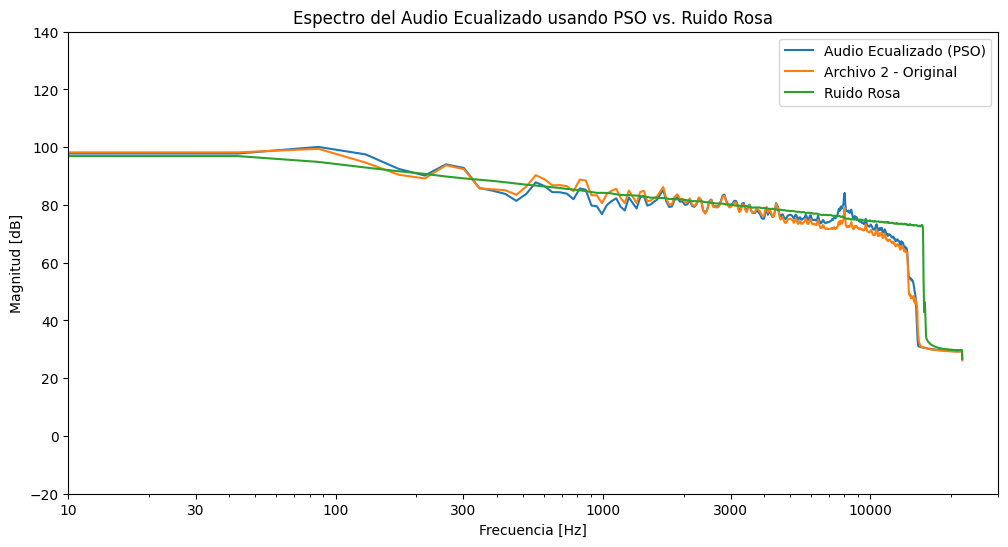

In [13]:
# Aplicar el aplanado de frecuencias altas al audio ecualizado
audio_ecualizado_pso_f, frequencies_ec_pso_f, power_ec_pso_db_f = flatten_high_frequencies(
    audio_ecualizado_pso, frequencies_ec_pso, power_ec_pso_db, power_rr_db, fs
)

# Mostrar el espectro del audio ecualizado vs. el ruido rosa
plt.figure(figsize=(12, 6))
plt.semilogx(frequencies_ec_pso_f, power_ec_pso_db_f, label='Audio Ecualizado (PSO)')
plt.semilogx(frequencies_o2, power_o2_db, label='Archivo 2 - Original')
plt.semilogx(frequencies_rr, power_rr_db, label='Ruido Rosa')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-20, 150, 20))
plt.ylim([-20, 140])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro del Audio Ecualizado usando PSO vs. Ruido Rosa')
plt.legend()
plt.show()

In [14]:
# Calcular el error entre el espectro del audio original y el audio ecualizado por PSO
mse, mae = calculate_error_spectrum(frequencies_ec_pso_f, power_ec_pso_db_f, frequencies_o2, power_o2_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 4.6703
Error Absoluto Medio (MAE): 1.5094


In [15]:
# Calcular el error entre el espectro del ruido rosa y el audio ecualizado por gradiente
mse, mae = calculate_error_spectrum(frequencies_ec, power_ec_db, frequencies_o2, power_o2_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 1.1727
Error Absoluto Medio (MAE): 0.8656


In [16]:
# Calcular el error entre el espectro del audio original y el audio ecualizado por PSO sin filtrar
mse, mae = calculate_error_spectrum(frequencies_ec_pso, power_ec_pso_db, frequencies_o2, power_o2_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 185.6826
Error Absoluto Medio (MAE): 9.1384


In [17]:
# Calcular el error entre el espectro del ruido rosa y el audio ecualizado por PSO sin filtrar
mse, mae = calculate_error_spectrum(frequencies_ec_pso, power_ec_pso_db, frequencies_rr, power_rr_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 176.3553
Error Absoluto Medio (MAE): 9.5129


In [18]:
# Calcular el error entre el espectro del ruido rosa y el audio ecualizado por PSO
mse, mae = calculate_error_spectrum(frequencies_ec_pso_f, power_ec_pso_db_f, frequencies_rr, power_rr_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 99.5160
Error Absoluto Medio (MAE): 4.7650


In [19]:
# Calcular el error entre el espectro del ruido rosa y el audio ecualizado por gradiente
mse, mae = calculate_error_spectrum(frequencies_ec, power_ec_db, frequencies_rr, power_rr_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 99.5537
Error Absoluto Medio (MAE): 5.5959


In [20]:
# Mostrar las ganancias finales aplicadas
print("Archivo - Ganancias finales aplicadas a cada banda (en dB):")
for i, g in enumerate(G_opt):
    print(f"Banda centrada en {fc[i]} Hz: {g:.2f} dB")

Archivo - Ganancias finales aplicadas a cada banda (en dB):
Banda centrada en 31.5 Hz: -6.11 dB
Banda centrada en 64.0 Hz: 4.22 dB
Banda centrada en 125.0 Hz: -0.76 dB
Banda centrada en 250.0 Hz: 8.66 dB
Banda centrada en 500.0 Hz: 6.26 dB
Banda centrada en 1000.0 Hz: 4.88 dB
Banda centrada en 2000.0 Hz: 8.09 dB
Banda centrada en 4000.0 Hz: 5.80 dB
Banda centrada en 8000.0 Hz: -2.06 dB
Banda centrada en 16000.0 Hz: -10.00 dB


# Prueba Bachata - La bachata

<ipython-input-21-f9780f801cd8>:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio1 = wavfile.read('/content/drive/My Drive/Archivos_prueba/Manuel-Turizo-La-Bachata_Dañado.wav')
<ipython-input-21-f9780f801cd8>:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, ruido_rosa = wavfile.read('/content/drive/My Drive/Archivos_prueba/Sonido de Ruido Rosa 1min.wav')


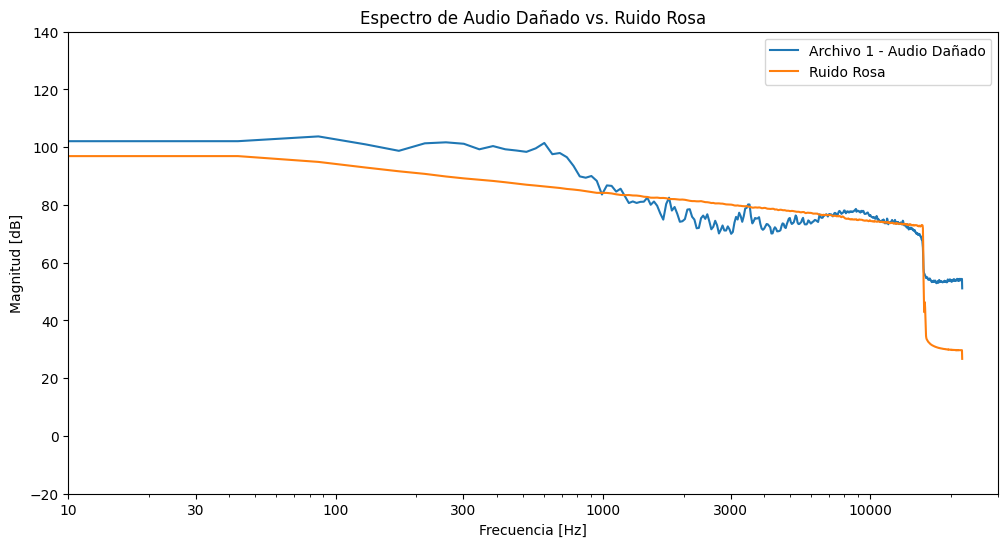

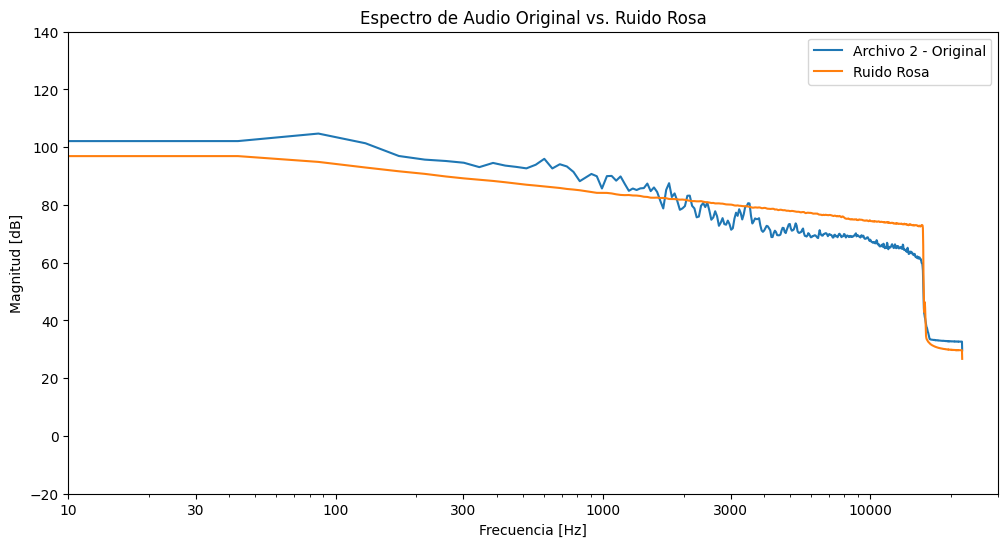

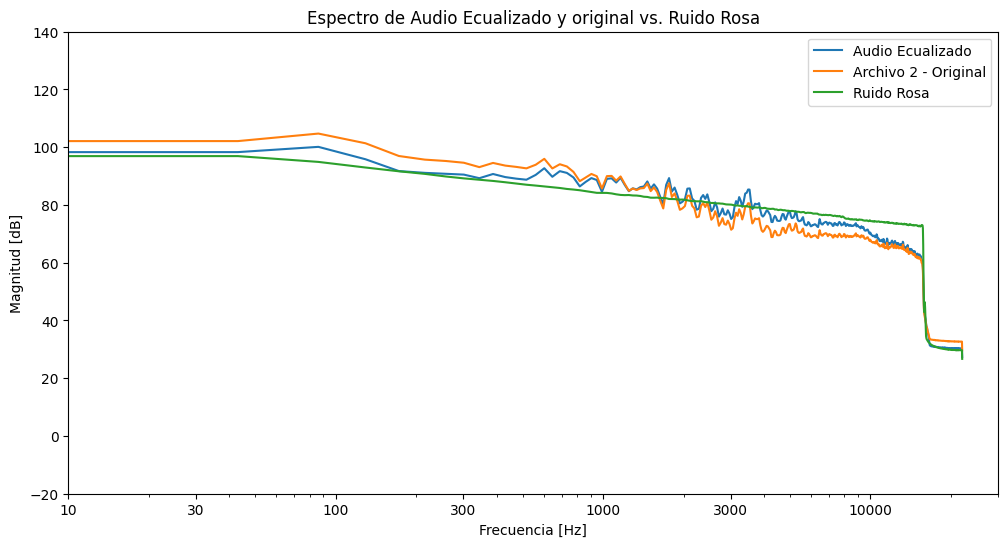

In [21]:

# Cargar los archivos de audio

# Cancion Dañada
fs, audio1 = wavfile.read('/content/drive/My Drive/Archivos_prueba/Manuel-Turizo-La-Bachata_Dañado.wav')
audio1 = convert_to_24bit(audio1)

# Ruido Rosa
_, ruido_rosa = wavfile.read('/content/drive/My Drive/Archivos_prueba/Sonido de Ruido Rosa 1min.wav')
ruido_rosa = convert_to_24bit(ruido_rosa)

# Cancion original
fs2, audio2 = wavfile.read('/content/drive/My Drive/Archivos_prueba/Manuel-Turizo-La-Bachata.wav')
audio2 = convert_to_24bit(audio2)

# Asegurarse de que el audio es mono
if len(audio1.shape) > 1:
    audio1 = audio1[:, 0]

if len(audio2.shape) > 1:
    audio2 = audio2[:, 0]

# Calcular el espectro del ruido rosa (asegurarse de que sea mono)
ruido_rosa_mono = ruido_rosa[:, 0] if len(ruido_rosa.shape) > 1 else ruido_rosa
frequencies_rr, power_rr = signal.welch(ruido_rosa_mono, fs=fs, window='hamming', nperseg=1024)
power_rr_db = 10 * np.log10(power_rr + np.finfo(float).eps)

# Definir parámetros del ecualizador (frecuencias centrales y anchos de banda)
fc = np.array([31.5, 64, 125, 250, 500, 1000, 2000, 4000, 8000, 16000])  # Frecuencias centrales
bw = np.array([1/3] * 10)  # Ancho de banda en octavas (fijo para simplificación)

# Ganancias iniciales (empezamos con 0 dB para cada banda)
G = np.zeros(len(fc))

# Obtener el espectro del ruido rosa como referencia
frequencies_rr, power_rr = signal.welch(ruido_rosa_mono, fs=fs, window='hamming', nperseg=1024)
power_rr_db = 10 * np.log10(power_rr + np.finfo(float).eps)

# Mostrar el espectro del audio original (archivo 1)
frequencies_o1, power_o1 = signal.welch(audio1, fs=fs, window='hamming', nperseg=1024)
power_o1_db = 10 * np.log10(power_o1 + np.finfo(float).eps)

# Mostrar el espectro del audio original (archivo 2)
frequencies_o2, power_o2 = signal.welch(audio2, fs=fs2, window='hamming', nperseg=1024)
power_o2_db = 10 * np.log10(power_o2 + np.finfo(float).eps)

plt.figure(figsize=(12, 6))
plt.semilogx(frequencies_o1, power_o1_db, label='Archivo 1 - Audio Dañado')
plt.semilogx(frequencies_rr, power_rr_db, label='Ruido Rosa')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-20, 150, 20))
plt.ylim([-20, 140])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de Audio Dañado vs. Ruido Rosa')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.semilogx(frequencies_o2, power_o2_db, label='Archivo 2 - Original')
plt.semilogx(frequencies_rr, power_rr_db, label='Ruido Rosa')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-20, 150, 20))
plt.ylim([-20, 140])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de Audio Original vs. Ruido Rosa')
plt.legend()
plt.show()

# Ajustar las ganancias del ecualizador para que el espectro se acerque al del ruido rosa
G, audio_ecualizado = adjust_gains(audio2, G, fc, bw, fs2, power_rr_db)

# Aplicar el aplanado de frecuencias altas al audio ecualizado
frequencies_ec, power_ec = signal.welch(audio_ecualizado, fs=fs2, window='hamming', nperseg=1024)
power_ec_db = 10 * np.log10(power_ec + np.finfo(float).eps)

# Mostrar el espectro del audio ecualizado antes del aplanado
plt.figure(figsize=(12, 6))
plt.semilogx(frequencies_ec, power_ec_db, label='Audio Ecualizado')
plt.semilogx(frequencies_o2, power_o2_db, label='Archivo 2 - Original')
plt.semilogx(frequencies_rr, power_rr_db, label='Ruido Rosa')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-20, 150, 20))
plt.ylim([-20, 140])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro de Audio Ecualizado y original vs. Ruido Rosa')
plt.legend()
plt.show()


In [22]:
# Calcular el error entre el espectro del audio original y el audio ecualizado por gradiente
mse, mae = calculate_error_spectrum(frequencies_ec, power_ec_db, frequencies_o2, power_o2_db)

# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 8.2212
Error Absoluto Medio (MAE): 2.5542


Ganancias aplicadas

In [23]:
# Mostrar las ganancias finales aplicadas (archivo 1)
print("Archivo 1 - Ganancias finales aplicadas a cada banda (en dB):")
for i, g in enumerate(G):
    print(f"Banda centrada en {fc[i]} Hz: {g:.2f} dB")

Archivo 1 - Ganancias finales aplicadas a cada banda (en dB):
Banda centrada en 31.5 Hz: -2.94 dB
Banda centrada en 64.0 Hz: -2.94 dB
Banda centrada en 125.0 Hz: -5.15 dB
Banda centrada en 250.0 Hz: -2.70 dB
Banda centrada en 500.0 Hz: -3.35 dB
Banda centrada en 1000.0 Hz: -0.84 dB
Banda centrada en 2000.0 Hz: 1.71 dB
Banda centrada en 4000.0 Hz: 4.74 dB
Banda centrada en 8000.0 Hz: 3.33 dB
Banda centrada en 16000.0 Hz: 3.49 dB


In [24]:
audio1n = normalize_audio_to_reference(audio1, ruido_rosa)

In [25]:

# Marcar el tiempo inicial
start_time = time.time()

# Valor para almacenar la mejor solución hasta el momento
best_fitness = np.inf  # Iniciar con valor infinito

# Parámetros del PSO
n_particles = 100  # Aumentar un poco el tamaño del enjambre para mejor exploración
max_iter = 15     # Limitar a 20 iteraciones como máximo
w = 0.25           # Coeficiente de inercia
c1 = 1.5          # Coeficiente cognitivo
c2 = 2.0          # Coeficiente social

# Ejecutar PSO con seguimiento y valores ajustados, sin callback
# Configuración del PSO con ajuste de parámetros para mejorar la búsqueda global
G_opt, fopt = pso(fitness_func, [-10]*len(fc), [10]*len(fc), swarmsize=n_particles, maxiter=max_iter,
                  omega=0.9, phip=1.5, phig=1.5, debug=True, minstep=1e-8, minfunc=1e-8)


# Aplicar las ganancias óptimas obtenidas al audio dañado
audio_ecualizado_pso = apply_eq(audio1n, G_opt, fc, bw, fs)



# Aplanar las frecuencias altas que exceden la referencia del audio original
frequencies_ec_pso, power_ec_pso = signal.welch(audio_ecualizado_pso, fs=fs, window='hamming', nperseg=1024)
power_ec_pso_db = 10 * np.log10(power_ec_pso + np.finfo(float).eps)

####

# Marcar el tiempo final
end_time = time.time()

# Calcular el tiempo transcurrido
elapsed_time = end_time - start_time

# Convertir a formato HH:MM:SS
hours, remainder = divmod(elapsed_time, 3600)
minutes, seconds = divmod(remainder, 60)

print("------ ------ ------")

# Mostrar el tiempo transcurrido en formato HH:MM:SS
print(f"Tiempo transcurrido: {int(hours):02}:{int(minutes):02}:{int(seconds):02}")

No constraints given.
Best after iteration 1: [-0.94396142  6.02092123 -4.90590773 -5.69273322 -8.40716509 -4.92236756
  4.43868867  8.43379763 -4.82066368 -9.72179717] 40745.15529202184
Best after iteration 2: [-0.94396142  6.02092123 -4.90590773 -5.69273322 -8.40716509 -4.92236756
  4.43868867  8.43379763 -4.82066368 -9.72179717] 40745.15529202184
Best after iteration 3: [-0.94396142  6.02092123 -4.90590773 -5.69273322 -8.40716509 -4.92236756
  4.43868867  8.43379763 -4.82066368 -9.72179717] 40745.15529202184
Best after iteration 4: [-0.94396142  6.02092123 -4.90590773 -5.69273322 -8.40716509 -4.92236756
  4.43868867  8.43379763 -4.82066368 -9.72179717] 40745.15529202184
Best after iteration 5: [-0.94396142  6.02092123 -4.90590773 -5.69273322 -8.40716509 -4.92236756
  4.43868867  8.43379763 -4.82066368 -9.72179717] 40745.15529202184
Best after iteration 6: [-0.94396142  6.02092123 -4.90590773 -5.69273322 -8.40716509 -4.92236756
  4.43868867  8.43379763 -4.82066368 -9.72179717] 40745.

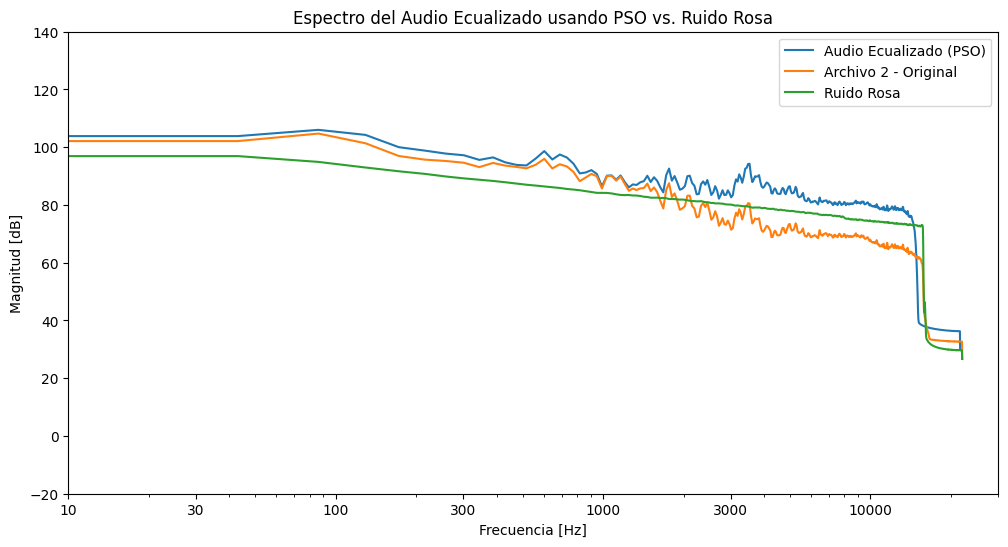

In [26]:
# Aplicar el aplanado de frecuencias altas al audio ecualizado
audio_ecualizado_pso_f, frequencies_ec_pso_f, power_ec_pso_db_f = flatten_high_frequencies(
    audio_ecualizado_pso, frequencies_ec_pso, power_ec_pso_db, power_rr_db, fs
)

# Mostrar el espectro del audio ecualizado vs. el ruido rosa
plt.figure(figsize=(12, 6))
plt.semilogx(frequencies_ec_pso_f, power_ec_pso_db_f, label='Audio Ecualizado (PSO)')
plt.semilogx(frequencies_o2, power_o2_db, label='Archivo 2 - Original')
plt.semilogx(frequencies_rr, power_rr_db, label='Ruido Rosa')
plt.xticks([10, 30, 100, 300, 1000, 3000, 10000], ['10', '30', '100', '300', '1000', '3000', '10000'])
plt.yticks(np.arange(-20, 150, 20))
plt.ylim([-20, 140])
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.title('Espectro del Audio Ecualizado usando PSO vs. Ruido Rosa')
plt.legend()
plt.show()

In [27]:
# Calcular el error entre el espectro del audio original y el audio ecualizado por PSO
mse, mae = calculate_error_spectrum(frequencies_ec_pso_f, power_ec_pso_db_f, frequencies_o2, power_o2_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 107.1295
Error Absoluto Medio (MAE): 9.0372


In [28]:
# Calcular el error entre el espectro del ruido rosa y el audio ecualizado por gradiente
mse, mae = calculate_error_spectrum(frequencies_ec, power_ec_db, frequencies_o2, power_o2_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 8.2212
Error Absoluto Medio (MAE): 2.5542


In [29]:
# Calcular el error entre el espectro del audio original y el audio ecualizado por PSO sin filtrar
mse, mae = calculate_error_spectrum(frequencies_ec_pso, power_ec_pso_db, frequencies_o2, power_o2_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 235.1516
Error Absoluto Medio (MAE): 14.1925


In [30]:
# Calcular el error entre el espectro del ruido rosa y el audio ecualizado por PSO sin filtrar
mse, mae = calculate_error_spectrum(frequencies_ec_pso, power_ec_pso_db, frequencies_rr, power_rr_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 195.8543
Error Absoluto Medio (MAE): 10.7823


In [31]:
# Calcular el error entre el espectro del ruido rosa y el audio ecualizado por PSO
mse, mae = calculate_error_spectrum(frequencies_ec_pso_f, power_ec_pso_db_f, frequencies_rr, power_rr_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 74.8087
Error Absoluto Medio (MAE): 6.6834


In [32]:
# Calcular el error entre el espectro del ruido rosa y el audio ecualizado por gradiente
mse, mae = calculate_error_spectrum(frequencies_ec, power_ec_db, frequencies_rr, power_rr_db)
# Imprimir los resultados del error
print(f"Error Cuadrático Medio (MSE): {mse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")

Error Cuadrático Medio (MSE): 21.2601
Error Absoluto Medio (MAE): 3.4708


In [33]:
# Mostrar las ganancias finales aplicadas
print("Archivo - Ganancias finales aplicadas a cada banda (en dB):")
for i, g in enumerate(G_opt):
    print(f"Banda centrada en {fc[i]} Hz: {g:.2f} dB")

Archivo - Ganancias finales aplicadas a cada banda (en dB):
Banda centrada en 31.5 Hz: 3.07 dB
Banda centrada en 64.0 Hz: -5.46 dB
Banda centrada en 125.0 Hz: 1.61 dB
Banda centrada en 250.0 Hz: -8.06 dB
Banda centrada en 500.0 Hz: -8.93 dB
Banda centrada en 1000.0 Hz: -1.80 dB
Banda centrada en 2000.0 Hz: 4.67 dB
Banda centrada en 4000.0 Hz: 8.72 dB
Banda centrada en 8000.0 Hz: -4.71 dB
Banda centrada en 16000.0 Hz: -10.00 dB
